In [3]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, mode="train"):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            mode: Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        #self.feature_extractor = feature_extractor
        self.mode = mode
        self.transforms = self.create_transforms()
        
        #sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, "input", self.mode)
        self.images = sorted([f for _, _, files in os.walk(self.img_dir) for f in files])
        self.ann_dir = os.path.join(self.root_dir, "target", self.mode)
        self.annotations = sorted([f for _, _, files in os.walk(self.ann_dir) for f in files])
        
    def create_transforms(self):
        _transforms = A.Compose([
            A.PadIfNeeded(min_height=256, min_width=256, border_mode=0, value=0, mask_value=255),
            A.Resize(height=256, width=256), 
            ToTensorV2(),
#             A.Normalize([0.485, 0.456, 0.406, 0], [0.229, 0.224, 0.225, 1])
        ], p = 1,
        )
        return _transforms
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = np.array(Image.open(os.path.join(self.img_dir, self.images[idx])).convert('RGB'))
        mask  = np.array(Image.open(os.path.join(self.ann_dir, self.annotations[idx])).convert('L'))
        mask[mask > 1] = 255 #change all non-valid label value to 255

        # transform
        encoded_inputs =  self.transforms(image = image, mask = mask)
        return encoded_inputs

In [4]:
from torch.utils.data import DataLoader

data_catalogue = './Forest_Deoldify_all/'
data_dir = data_catalogue

train_dataset = SemanticSegmentationDataset(root_dir=data_dir,mode="train")
valid_dataset = SemanticSegmentationDataset(root_dir=data_dir,mode="val")

Length of training dataset: 1397
Length of validation dataset: 820
Image shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])


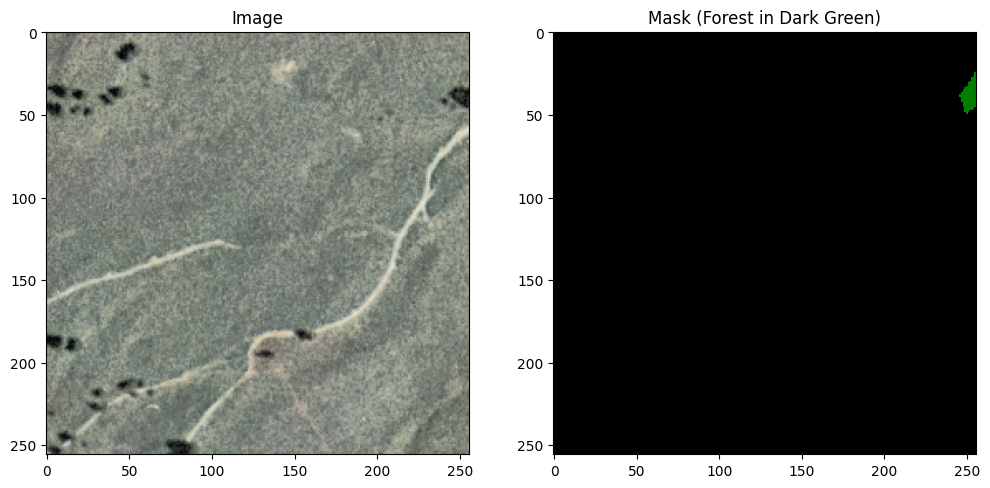

In [5]:
# Check the train data on a random sample
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

print('Length of training dataset:',len(train_dataset))
print('Length of validation dataset:',len(valid_dataset))

random_index = random.randint(0, len(train_dataset) - 1)

sample = train_dataset[random_index]  # Get the first sample
print(f"Image shape: {sample['image'].shape}")
print(f"Mask shape: {sample['mask'].shape}")

def show_sample(image, mask):
    colors = [(0, 0, 0), (0, 0.5, 0), (0.5, 0.5, 0.5)]
    n_bins = [3]  # Discretizes the interpolation into bins
    cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors, N=3)
    # Adjust mask for 'NoData' to be white or transparent
    mask_display = np.copy(mask)
    mask_display[mask == 255] = 2  # 2 corresponds to grey in the custom colormap
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Image")
    plt.subplot(1, 2, 2)
    plt.imshow(mask_display, cmap=cmap, interpolation='nearest', vmin=0, vmax=2)
    plt.title("Mask (Forest in Dark Green)")
    plt.show()

# Convert tensor to numpy for visualization
sample = train_dataset[random_index]
image = sample['image'].numpy().transpose(1, 2, 0)  # Assuming image is in CxHxW format
mask = sample['mask'].numpy()  # Assuming mask is in HxW format
show_sample(image, mask)

In [6]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=8)

In [7]:
# Load pretrained segformer model from HuggingFace
from transformers import SegformerForSemanticSegmentation
id2label = {0: 'Non-Forest', 
            1: 'Forest',
            255: 'NoData'}
label2id = {'Non-Forest' : 0, 
            'Forest': 1,
            'NoData':255}
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=3, 
                                                         id2label=id2label, 
                                                         label2id=label2id,)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.3.proj.bias', 'decode_head.classifier.weight', 'decode_head.linear_fuse.weight', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.1.proj.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.1.proj.weight', 'decode_head.batch_norm.weight', 'decode_head.linear_c.3.proj.weight', 'decode_head.batch_norm.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.2.proj.weight', 'decode_head.classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# Train model
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

from datasets import load_metric
metric = load_metric("mean_iou")

epochs = 20

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(epochs): 
    print("Epoch:", epoch+1)
    for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["image"].to(device).float()
        labels = batch["mask"].to(device).long()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        
        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
            upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
            predicted = upsampled_logits.argmax(dim=1)
            # note that the metric expects predictions + labels as numpy arrays
            metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        if idx % 100 == 0:
            metrics = metric._compute(references = labels.cpu(), 
                                      predictions = predicted.cpu(),
                                      num_labels=len(id2label), 
                                      ignore_index=255,
                                      reduce_labels=False, # we've already reduced the labels before)
          )

            print("Loss:", loss.item())
            print("Mean_iou:", metrics["mean_iou"])
            print("Mean accuracy:", metrics["mean_accuracy"])

# Save the model
import os
os.makedirs(f'./segformer_model/{data_catalogue}', exist_ok = True)
model.save_pretrained(save_directory = f'./segformer_model/{data_catalogue}')

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.3.proj.weight', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.classifier.bias', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.batch_norm.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.0.proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
